In [241]:
import math
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import svm
from itertools import cycle

In [242]:
%matplotlib inline

## Helper Functions ##

In [318]:
def cross_val_t_test(x1, x2, s1, s2, k_folds):
    """ Returns the probability from a one sided t-test
        for cross-validation. x1, x2 are the mean scores,
        s1, s2, the standard deviance, k_folds the number
        of folds used in cross validation. 
    """
    from scipy import stats
    import math
    df = k_folds - 1
    t = abs(x1 - x2) / math.sqrt( s1**2/k_folds + s2**2/k_folds)
    cdf = stats.t.cdf(t,df=df)
    return 1 - cdf

def best_model_gridsearchCV(X, y, param_grid, classifier, cv=5, n_jobs=-1, verbose=10):
    """ Returns the best model generated by sk.model_selection.GridSearchCV
        X is a dataFrame or numpy array of values. y is a 1d numpy array.
        param_grid is a dictionary of parameters. classifier is a
        scikit-learn classifier object.
    """
    cl = sk.model_selection.GridSearchCV(classifier, param_grid, cv=cv, n_jobs=n_jobs, verbose=verbose)
    cl = cl.fit(X, y)
    results = pd.DataFrame(cl.cv_results_)
    print("Best Model Hyperparameters:", cl.best_estimator_)
    print("Best Model average classification score:", cl.best_score_)
    means = cl.cv_results_['mean_test_score']
    stds = cl.cv_results_['std_test_score']
    print("\nGrid Search Scores:\n")
    for mean, std, params in zip(means, stds, cl.cv_results_['params']):
        print(mean, std, params)
    best_mean = cl.best_score_
    best_std = results.loc[results['mean_test_score']==best_mean, 'std_test_score'].iloc[0]
    return best_mean, best_std, results, cl

def gen_confusion_matrix(X_test, y_test, fitted_classifier):
    """ Returns a classification report and pandas DataFrame for the confusion matrix
    """
    print("Classification Report:\n")
    y_pred = fitted_classifier.predict(X_test)
    unique_labels = np.unique([y_test, y_pred])
    report = sk.metrics.classification_report(y_test, y_pred)
    print(report)
    con_mats_df = pd.DataFrame(sk.metrics.confusion_matrix(y_test, y_pred, labels=unique_labels),
                              index=['true:{:}'.format(x) for x in unique_labels],
                              columns=['pred:{:}'.format(x) for x in unique_labels])
    print("Confusion Matrix:\n")
    print(con_mats_df)
    return report, con_mats_df

def plot_multiclass_roc_curve(X_test, y_test, cl, title, savename, savepath, knn=False):
    """Plots the multiclass ROC curve."""
    n_class = len(np.unique(y_test))
    classes = np.unique(y_test)
    y_test_bin = sk.preprocessing.label_binarize(y_test, classes=classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if knn:
        y_score = cl.predict_proba(X_test)  # annoying force as knn does not have decision_function method
    else:
        y_score = cl.decision_function(X_test)
    for i in range(n_class):
        fpr[i], tpr[i], _ = sk.metrics.roc_curve(y_test_bin[:,i], y_score[:, i])
        roc_auc[i] = sk.metrics.auc(fpr[i], tpr[i])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_class)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_class):
        mean_tpr += sp.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_class
    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = sk.metrics.auc(fpr['macro'], tpr['macro'])

    ## Plots ##
    lw = 0.7
    plt.figure(figsize=(20,10))
    plt.plot(fpr['macro'], tpr['macro'], label='Macro Averaged ROC curve (area = {0:0.2f})'.format(roc_auc['macro']),
            color='red', linestyle=':', linewidth=4)
    colors = cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])
    for i, color in zip(range(n_class), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))
    plt.plot([0,1],[0,1], 'k--', lw=4)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    fname = savepath+savename+'.png'
    plt.savefig(fname)
    plt.show()
    return 0

## FMA Modeling ##
Let's begin exploring the FMA_small dataset. We'll start by loading the time and frequency domain features constructed from the dataset located in *extracted_audio_features_fma_small_dataset.csv*. We also need to join the genres located in *fma_clean_genres.csv*.

In [244]:
# imports for loading datasets
import pandas as pd
dataMatrix = pd.read_csv(r'D:\Analytics\extracted_audio_features_fma_small_dataset.csv', index_col=0)
genreMatrix = pd.read_csv(r'D:\Analytics\fma_clean_genres.csv', index_col=0)
print(len(dataMatrix), len(genreMatrix))

7995 109727


In [245]:
dataMatrix.head()

,names,x_mean,x_stdev,x_kurtosis,x_skew,zcr_mean,zcr_stdev,zcr_kurtosis,zcr_skew,rms_mean,rms_stdev,rms_kurtosis,rms_skew,tempo,mean_dynamic_tempo,stdev_dynamic_tempo,kurtosis_dynamic_tempo,skew_dynamic_tempo,length,mfcc_mean,mfcc_stdev,mfcc_kurtosis,mfcc_skew,chroma_mean,chroma_stdev,chroma_kurtosis,chroma_skew,spectra_centroid_mean,spectral_centroid_stdev,spectral_centroid_kurtosis,spectral_centroid_skew,spectral_bandwidth_mean,spectral_bandwidth_stdev,spectral_bandwidth_kurtosis,spectral_bandwidth_skew,spectral_contrast_mean,spectral_contrast_stdev,spectral_contrast_kurtosis,spectral_contrast_skew,spectal_rolloff_mean,spectral_rolloff_stdev,spectral_rolloff_kurtosis,spectral_rolloff_skew,spectral_flatness_mean,spectral_flatness_stdev,spectral_flatness_kurtosis,spectral_flatness_skew
0,fma_small\004\004849.mp3,-5.540000e-05,0.094732,1.405296,0.109443,0.036622,0.015446,0.368767,0.007812,0.081343,0.048523,-0.508646,0.400302,129.199219,116.057249,13.523365,-1.446340,-1.446340,29.976576,-6.190333,78.656864,10.942578,-2.513902,0.381312,0.294891,-0.476253,0.849955,862.814190,195.841881,4.678505,0.575661,1235.504267,174.546616,5.394988,1.574932,24.180353,8.453981,-0.408714,0.417988,1542.897371,454.278915,9.580656,0.801681,0.000094,0.000235,218.012832,12.258998
0,fma_small\000\000002.mp3,3.131910e-04,0.166016,3.161952,-0.008753,0.098366,0.068404,3.496868,1.825609,0.141235,0.087225,1.256372,1.295198,166.708669,151.252396,24.971450,-0.169359,-0.169359,29.976576,-1.255037,44.957669,7.116079,-0.488827,0.637587,0.207228,-0.821492,0.118739,1842.291742,700.993537,1.136937,1.221557,1748.564847,299.211364,0.372977,0.397007,20.072165,12.262117,1.607168,1.661760,3709.932382,1143.797297,-0.349026,0.461345,0.000956,0.001826,45.821934,5.722371
0,fma_small\043\043842.mp3,-5.900000e-06,0.096036,0.683987,-0.072567,0.030740,0.011371,3.241493,1.193829,0.091412,0.029400,0.230696,0.321780,112.347147,111.863700,3.952476,-0.691430,-0.691430,30.002698,-4.814693,68.705233,8.471082,-1.469262,0.509667,0.253366,-0.765644,0.505868,875.664850,320.523096,3.363020,1.693295,1323.632559,372.352087,1.238664,1.223722,21.867556,8.736492,0.394949,1.021540,1737.392125,1053.824911,3.188415,1.893030,0.000118,0.000298,77.033202,7.394355
0,fma_small\024\024745.mp3,-6.840000e-06,0.002337,4.743158,0.010256,0.150333,0.045382,0.262682,0.407087,0.002092,0.001043,0.297424,0.661104,126.048018,127.832444,5.219731,11.388176,11.388176,29.976576,-20.694630,120.823732,13.810281,-3.708112,0.691191,0.192113,-0.665367,-0.176773,2328.595021,563.682060,0.288272,0.750030,2208.622586,361.567091,-0.501479,0.513081,18.372763,8.992594,-0.565770,0.617952,4919.098463,1225.944539,-0.639003,0.254632,0.010913,0.016450,26.958460,4.130177
0,fma_small\031\031390.mp3,3.070000e-07,0.095171,0.776142,0.063080,0.018225,0.011794,33.303192,4.037206,0.088375,0.035313,-0.409662,0.473642,123.046875,123.287199,0.814549,7.574971,7.574971,30.002698,-5.526642,77.496249,9.437461,-2.172789,0.567815,0.230850,-0.841282,0.381673,637.689351,232.021707,25.650214,3.509963,1181.282092,213.359511,7.426956,1.819323,22.790993,7.954318,-0.094249,0.647226,1153.325856,582.813426,11.549484,2.480383,0.000082,0.000251,218.690556,13.352615


In [246]:
genreMatrix.head()

,track id,genre
0,2,Hip-Hop
1,3,Hip-Hop
2,5,Hip-Hop
3,10,Pop
4,20,Pop


There are some important things to take note of. First, the row length of the dataMatrix of extracted features is only 7995 instead of 8000. This is due to 5 of the tracks being corrupted when extracted the audio features with Librosa. The second is that the genreMatrix contains the genres and track ids for all of the music in the FMA. We will join these two dataframes into a single frame on track_id == track_id. To do this, we first need to grab the track ids from the names column in the dataMatrix dataframe.

In [247]:
ids = [int(s.split("\\")[-1][:-4]) for s in dataMatrix['names'].tolist()]
dataMatrix['ids'] = ids
dataMatrix.head()

,names,x_mean,x_stdev,x_kurtosis,x_skew,zcr_mean,zcr_stdev,zcr_kurtosis,zcr_skew,rms_mean,rms_stdev,rms_kurtosis,rms_skew,tempo,mean_dynamic_tempo,stdev_dynamic_tempo,kurtosis_dynamic_tempo,skew_dynamic_tempo,length,mfcc_mean,mfcc_stdev,mfcc_kurtosis,mfcc_skew,chroma_mean,chroma_stdev,chroma_kurtosis,chroma_skew,spectra_centroid_mean,spectral_centroid_stdev,spectral_centroid_kurtosis,spectral_centroid_skew,spectral_bandwidth_mean,spectral_bandwidth_stdev,spectral_bandwidth_kurtosis,spectral_bandwidth_skew,spectral_contrast_mean,spectral_contrast_stdev,spectral_contrast_kurtosis,spectral_contrast_skew,spectal_rolloff_mean,spectral_rolloff_stdev,spectral_rolloff_kurtosis,spectral_rolloff_skew,spectral_flatness_mean,spectral_flatness_stdev,spectral_flatness_kurtosis,spectral_flatness_skew,ids
0,fma_small\004\004849.mp3,-5.540000e-05,0.094732,1.405296,0.109443,0.036622,0.015446,0.368767,0.007812,0.081343,0.048523,-0.508646,0.400302,129.199219,116.057249,13.523365,-1.446340,-1.446340,29.976576,-6.190333,78.656864,10.942578,-2.513902,0.381312,0.294891,-0.476253,0.849955,862.814190,195.841881,4.678505,0.575661,1235.504267,174.546616,5.394988,1.574932,24.180353,8.453981,-0.408714,0.417988,1542.897371,454.278915,9.580656,0.801681,0.000094,0.000235,218.012832,12.258998,4849
0,fma_small\000\000002.mp3,3.131910e-04,0.166016,3.161952,-0.008753,0.098366,0.068404,3.496868,1.825609,0.141235,0.087225,1.256372,1.295198,166.708669,151.252396,24.971450,-0.169359,-0.169359,29.976576,-1.255037,44.957669,7.116079,-0.488827,0.637587,0.207228,-0.821492,0.118739,1842.291742,700.993537,1.136937,1.221557,1748.564847,299.211364,0.372977,0.397007,20.072165,12.262117,1.607168,1.661760,3709.932382,1143.797297,-0.349026,0.461345,0.000956,0.001826,45.821934,5.722371,2
0,fma_small\043\043842.mp3,-5.900000e-06,0.096036,0.683987,-0.072567,0.030740,0.011371,3.241493,1.193829,0.091412,0.029400,0.230696,0.321780,112.347147,111.863700,3.952476,-0.691430,-0.691430,30.002698,-4.814693,68.705233,8.471082,-1.469262,0.509667,0.253366,-0.765644,0.505868,875.664850,320.523096,3.363020,1.693295,1323.632559,372.352087,1.238664,1.223722,21.867556,8.736492,0.394949,1.021540,1737.392125,1053.824911,3.188415,1.893030,0.000118,0.000298,77.033202,7.394355,43842
0,fma_small\024\024745.mp3,-6.840000e-06,0.002337,4.743158,0.010256,0.150333,0.045382,0.262682,0.407087,0.002092,0.001043,0.297424,0.661104,126.048018,127.832444,5.219731,11.388176,11.388176,29.976576,-20.694630,120.823732,13.810281,-3.708112,0.691191,0.192113,-0.665367,-0.176773,2328.595021,563.682060,0.288272,0.750030,2208.622586,361.567091,-0.501479,0.513081,18.372763,8.992594,-0.565770,0.617952,4919.098463,1225.944539,-0.639003,0.254632,0.010913,0.016450,26.958460,4.130177,24745
0,fma_small\031\031390.mp3,3.070000e-07,0.095171,0.776142,0.063080,0.018225,0.011794,33.303192,4.037206,0.088375,0.035313,-0.409662,0.473642,123.046875,123.287199,0.814549,7.574971,7.574971,30.002698,-5.526642,77.496249,9.437461,-2.172789,0.567815,0.230850,-0.841282,0.381673,637.689351,232.021707,25.650214,3.509963,1181.282092,213.359511,7.426956,1.819323,22.790993,7.954318,-0.094249,0.647226,1153.325856,582.813426,11.549484,2.480383,0.000082,0.000251,218.690556,13.352615,31390


In [ ]:
merged = dataMatrix.join(genreMatrix.set_index('track id'), on='ids')
merged.to_csv('fma_small_cleaned_and_merged.csv')

In [248]:
# Can pickup here on reload
import pandas as pd
merged = pd.read_csv('fma_small_cleaned_and_merged.csv', index_col=0)
merged.head()

,names,x_mean,x_stdev,x_kurtosis,x_skew,zcr_mean,zcr_stdev,zcr_kurtosis,zcr_skew,rms_mean,rms_stdev,rms_kurtosis,rms_skew,tempo,mean_dynamic_tempo,stdev_dynamic_tempo,kurtosis_dynamic_tempo,skew_dynamic_tempo,length,mfcc_mean,mfcc_stdev,mfcc_kurtosis,mfcc_skew,chroma_mean,chroma_stdev,chroma_kurtosis,chroma_skew,spectra_centroid_mean,spectral_centroid_stdev,spectral_centroid_kurtosis,spectral_centroid_skew,spectral_bandwidth_mean,spectral_bandwidth_stdev,spectral_bandwidth_kurtosis,spectral_bandwidth_skew,spectral_contrast_mean,spectral_contrast_stdev,spectral_contrast_kurtosis,spectral_contrast_skew,spectal_rolloff_mean,spectral_rolloff_stdev,spectral_rolloff_kurtosis,spectral_rolloff_skew,spectral_flatness_mean,spectral_flatness_stdev,spectral_flatness_kurtosis,spectral_flatness_skew,ids,genre
0,fma_small\004\004849.mp3,-5.540000e-05,0.094732,1.405296,0.109443,0.036622,0.015446,0.368767,0.007812,0.081343,0.048523,-0.508646,0.400302,129.199219,116.057249,13.523365,-1.446340,-1.446340,29.976576,-6.190333,78.656864,10.942578,-2.513902,0.381312,0.294891,-0.476253,0.849955,862.814190,195.841881,4.678505,0.575661,1235.504267,174.546616,5.394988,1.574932,24.180353,8.453981,-0.408714,0.417988,1542.897371,454.278915,9.580656,0.801681,0.000094,0.000235,218.012832,12.258998,4849,International
0,fma_small\000\000002.mp3,3.131910e-04,0.166016,3.161952,-0.008753,0.098366,0.068404,3.496868,1.825609,0.141235,0.087225,1.256372,1.295198,166.708669,151.252396,24.971450,-0.169359,-0.169359,29.976576,-1.255037,44.957669,7.116079,-0.488827,0.637587,0.207228,-0.821492,0.118739,1842.291742,700.993537,1.136937,1.221557,1748.564847,299.211364,0.372977,0.397007,20.072165,12.262117,1.607168,1.661760,3709.932382,1143.797297,-0.349026,0.461345,0.000956,0.001826,45.821934,5.722371,2,Hip-Hop
0,fma_small\043\043842.mp3,-5.900000e-06,0.096036,0.683987,-0.072567,0.030740,0.011371,3.241493,1.193829,0.091412,0.029400,0.230696,0.321780,112.347147,111.863700,3.952476,-0.691430,-0.691430,30.002698,-4.814693,68.705233,8.471082,-1.469262,0.509667,0.253366,-0.765644,0.505868,875.664850,320.523096,3.363020,1.693295,1323.632559,372.352087,1.238664,1.223722,21.867556,8.736492,0.394949,1.021540,1737.392125,1053.824911,3.188415,1.893030,0.000118,0.000298,77.033202,7.394355,43842,Folk
0,fma_small\024\024745.mp3,-6.840000e-06,0.002337,4.743158,0.010256,0.150333,0.045382,0.262682,0.407087,0.002092,0.001043,0.297424,0.661104,126.048018,127.832444,5.219731,11.388176,11.388176,29.976576,-20.694630,120.823732,13.810281,-3.708112,0.691191,0.192113,-0.665367,-0.176773,2328.595021,563.682060,0.288272,0.750030,2208.622586,361.567091,-0.501479,0.513081,18.372763,8.992594,-0.565770,0.617952,4919.098463,1225.944539,-0.639003,0.254632,0.010913,0.016450,26.958460,4.130177,24745,International
0,fma_small\031\031390.mp3,3.070000e-07,0.095171,0.776142,0.063080,0.018225,0.011794,33.303192,4.037206,0.088375,0.035313,-0.409662,0.473642,123.046875,123.287199,0.814549,7.574971,7.574971,30.002698,-5.526642,77.496249,9.437461,-2.172789,0.567815,0.230850,-0.841282,0.381673,637.689351,232.021707,25.650214,3.509963,1181.282092,213.359511,7.426956,1.819323,22.790993,7.954318,-0.094249,0.647226,1153.325856,582.813426,11.549484,2.480383,0.000082,0.000251,218.690556,13.352615,31390,Folk


In [249]:
print(len(merged))

7995


## Exploratory Data Analysis ##
Now that we have our compete dataset in a frame to work with, we can start doing some EDA. Let's start by seeing what the genre composition of our dataset is.

In [250]:
merged['genre'] = pd.Categorical(merged.genre)

In [251]:
merged.genre.value_counts()

Pop              1000
Instrumental     1000
Hip-Hop          1000
Rock              999
International     999
Folk              999
Experimental      999
Electronic        999
Name: genre, dtype: int64

It looks as though the corrupted files lived in Rock, International, Folk, Experimental, and Electronic. This means that we have the *slightest* bias towards Pop, Instrumental, and Hip-hop, although this bias will be within whatever error we have.

Let's look at the entire dataMatrix to check for outliers with *pd.DataFrame.describe()*

In [252]:
pd.options.display.max_columns = 100
merged.describe()

,x_mean,x_stdev,x_kurtosis,x_skew,zcr_mean,zcr_stdev,zcr_kurtosis,zcr_skew,rms_mean,rms_stdev,rms_kurtosis,rms_skew,tempo,mean_dynamic_tempo,stdev_dynamic_tempo,kurtosis_dynamic_tempo,skew_dynamic_tempo,length,mfcc_mean,mfcc_stdev,mfcc_kurtosis,mfcc_skew,chroma_mean,chroma_stdev,chroma_kurtosis,chroma_skew,spectra_centroid_mean,spectral_centroid_stdev,spectral_centroid_kurtosis,spectral_centroid_skew,spectral_bandwidth_mean,spectral_bandwidth_stdev,spectral_bandwidth_kurtosis,spectral_bandwidth_skew,spectral_contrast_mean,spectral_contrast_stdev,spectral_contrast_kurtosis,spectral_contrast_skew,spectal_rolloff_mean,spectral_rolloff_stdev,spectral_rolloff_kurtosis,spectral_rolloff_skew,spectral_flatness_mean,spectral_flatness_stdev,spectral_flatness_kurtosis,spectral_flatness_skew,ids
count,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7995.000000,7.995000e+03,7.995000e+03,7995.000000,7995.000000,7995.000000
mean,-0.000322,0.190799,1.783591,0.004207,0.049379,0.029559,7.170516,1.784701,0.178776,0.062778,1.017909,0.515748,122.742791,122.310935,10.492049,10.607724,10.607724,29.977367,-0.311836,60.609114,9.280602,-0.756782,0.621389,0.214361,-0.647764,0.102900,1163.567734,461.058632,3.151952,1.202581,1420.587112,353.377684,1.280017,0.592038,20.087941,9.815399,1.012467,1.184911,2369.352075,1026.770708,3.012492,0.983493,2.802510e-03,5.145858e-03,194.124377,8.436407,84118.910319
std,0.023650,0.096995,7.371443,0.151424,0.030757,0.020961,12.923060,1.392005,0.096663,0.033491,6.615499,0.836105,18.584460,13.340803,9.499397,69.201659,69.201659,0.557507,6.226734,17.900602,3.832587,1.546317,0.096865,0.036888,0.371404,0.385186,541.625661,269.227627,6.244693,0.983643,485.789542,171.087969,7.565124,0.885465,1.840465,1.855594,1.021984,0.465082,1214.072019,558.938141,18.157336,1.279673,2.044131e-02,1.696141e-02,509.124949,9.927684,43292.813168
min,-0.620540,0.000000,-3.000000,-1.548959,0.000000,0.000000,-3.000000,-3.359748,0.000000,0.000000,-3.000000,-7.473562,57.421875,64.862165,0.000000,-3.000000,-3.000000,0.510454,-56.568542,19.910577,0.540479,-6.319643,0.000000,0.000000,-3.000000,-1.907774,0.000000,0.000000,-3.000000,-5.217277,0.000000,0.000000,-3.000000,-4.081976,0.000000,0.000000,-3.000000,-0.864162,0.000000,0.000000,-3.000000,-35.517054,1.470000e-08,2.430000e-08,-2.000000,-7.281556,2.000000
25%,-0.000062,0.117585,0.151476,-0.042541,0.029859,0.014972,0.788492,0.825735,0.106180,0.037914,-0.361290,0.041793,112.347147,114.749548,2.723324,-1.098478,-1.098478,29.976576,-3.744731,47.554340,7.137888,-1.940039,0.559885,0.191085,-0.828459,-0.157748,779.489382,257.765341,0.063494,0.558744,1090.798181,234.085629,-0.517061,0.066904,18.999111,8.620842,0.508378,0.931274,1477.240700,604.595754,-0.509331,0.248708,1.054765e-04,2.360965e-04,16.812760,3.525323,49063.000000
50%,-0.000003,0.182345,0.784791,0.000311,0.043905,0.024261,3.301644,1.532404,0.167861,0.056496,0.198062,0.471168,122.282609,122.109722,7.963668,0.472543,0.472543,29.976576,0.887635,57.918107,8.440999,-0.789346,0.630488,0.215805,-0.726070,0.095442,1106.632533,419.378648,1.225426,1.039663,1410.451632,337.593740,0.127996,0.516417,20.008852,10.065517,1.025318,1.308091,2259.310041,976.064435,0.445551,0.800547,4.878070e-04,1.286232e-03,40.037985,5.376337,89196.000000
75%,0.000033,0.252718,1.908062,0.045733,0.062000,0.038605,8.890938,2.451458,0.238326,0.081323,1.129287,0.943236,132.512019,129.199219,15.955265,5.538231,5.538231,30.002698,4.293682,70.737163,10.473954,0.393264,0.690012,0.239623,-0.570094,0.355250,1464.143362,620.274518,3.818200,1.669276,1733.023580

The important thing to look for here is for values that don't make sense: ie tempo having all positive values, spectra having positive values, tempo being realistic (mean ~ 70 - 140 BPM, nothing over 300 BPM), and amplitudes (X) within -1 to 1.

In [253]:
X = merged.loc[:, features]
y = merged.loc[:, 'genre'].to_numpy()

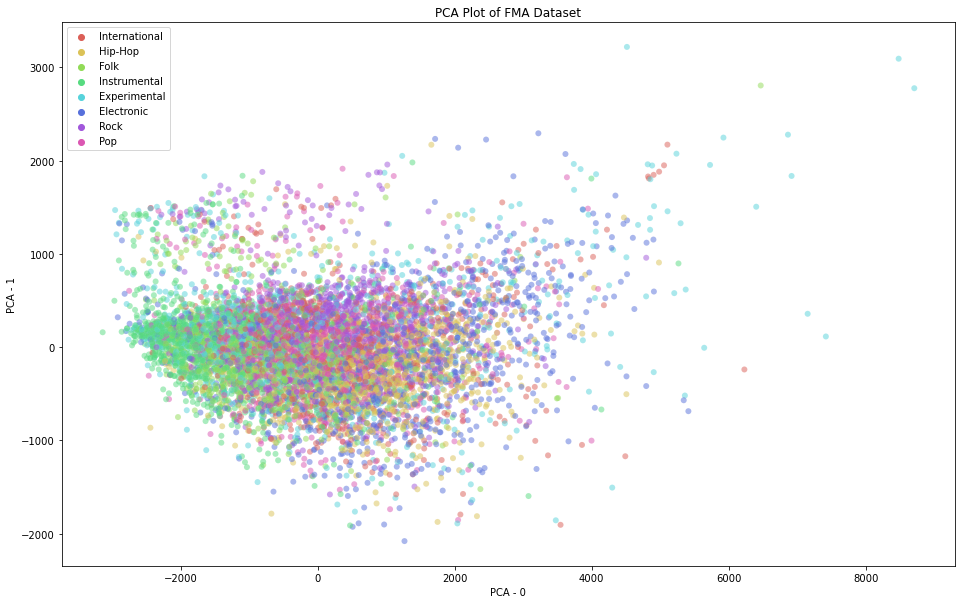

In [254]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_result[:,0], y=pca_result[:,1], hue=y, palette=sns.color_palette('hls',8),
    data=X, legend="full", alpha=0.5, linewidth = 0.05)
plt.xlabel('PCA - 0')
plt.ylabel('PCA - 1')
plt.title('PCA Plot of FMA Dataset')
plt.savefig('D:\\Analytics\\ROC Plots\\PCA Plot.png')
plt.show()

In [255]:
tsne = TSNE(n_components=2, verbose=10, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7995 samples in 0.089s...
[t-SNE] Computed neighbors for 7995 samples in 1.016s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7995
[t-SNE] Computed conditional probabilities for sample 2000 / 7995
[t-SNE] Computed conditional probabilities for sample 3000 / 7995
[t-SNE] Computed conditional probabilities for sample 4000 / 7995
[t-SNE] Computed conditional probabilities for sample 5000 / 7995
[t-SNE] Computed conditional probabilities for sample 6000 / 7995
[t-SNE] Computed conditional probabilities for sample 7000 / 7995
[t-SNE] Computed conditional probabilities for sample 7995 / 7995
[t-SNE] Mean sigma: 74.191706
[t-SNE] Computed conditional probabilities in 0.861s
[t-SNE] Iteration 50: error = 90.7324600, gradient norm = 0.0214906 (50 iterations in 1.845s)
[t-SNE] Iteration 100: error = 75.5699463, gradient norm = 0.0050067 (50 iterations in 1.651s)
[t-SNE] Iteration 150: error = 73.3363113, gradient norm =

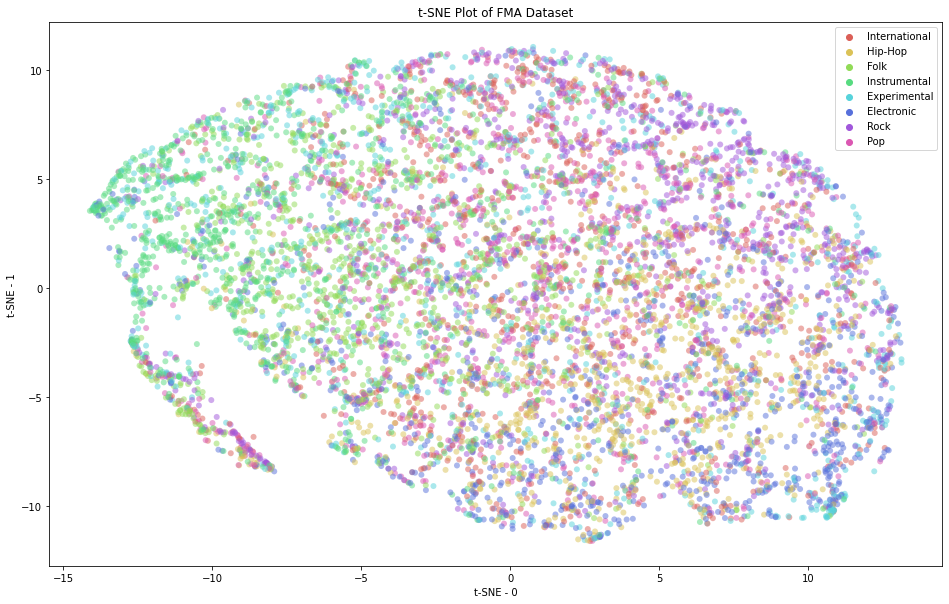

In [256]:
tsne_x = tsne_results[:,0]
tsne_y = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_x, y=tsne_y,
    hue=y, palette=sns.color_palette('hls', 8),
    data=X, legend="full", alpha=0.5, linewidth=0.05)
plt.xlabel('t-SNE - 0')
plt.ylabel('t-SNE - 1')
plt.title('t-SNE Plot of FMA Dataset')
plt.savefig('D:\\Analytics\\ROC Plots\\TSNE Plot.png')
plt.show()

# Modeling #
## SVM ##
Let's start by looking at SVM classifiers.

In [257]:
# set training and test split as 80-20
features = merged.columns[1:-2]
print(features)
X = merged.loc[:, features]
y = merged.loc[:, 'genre'].to_numpy()
X.shape, y.shape

Index(['x_mean', 'x_stdev', 'x_kurtosis', 'x_skew', 'zcr_mean', 'zcr_stdev',
       'zcr_kurtosis', 'zcr_skew', 'rms_mean', 'rms_stdev', 'rms_kurtosis',
       'rms_skew', 'tempo', 'mean_dynamic_tempo', 'stdev_dynamic_tempo',
       'kurtosis_dynamic_tempo', 'skew_dynamic_tempo', 'length', 'mfcc_mean',
       'mfcc_stdev', 'mfcc_kurtosis', 'mfcc_skew', 'chroma_mean',
       'chroma_stdev', 'chroma_kurtosis', 'chroma_skew',
       'spectra_centroid_mean', 'spectral_centroid_stdev',
       'spectral_centroid_kurtosis', 'spectral_centroid_skew',
       'spectral_bandwidth_mean', 'spectral_bandwidth_stdev',
       'spectral_bandwidth_kurtosis', 'spectral_bandwidth_skew',
       'spectral_contrast_mean', 'spectral_contrast_stdev',
       'spectral_contrast_kurtosis', 'spectral_contrast_skew',
       'spectal_rolloff_mean', 'spectral_rolloff_stdev',
       'spectral_rolloff_kurtosis', 'spectral_rolloff_skew',
       'spectral_flatness_mean', 'spectral_flatness_stdev',
       'spectral_flatne

((7995, 46), (7995,))

In [258]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [259]:
print(y_train.shape, X_train.shape)
print(type(y_train))
print(type(X_train))

(6396,) (6396, 46)
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [260]:
svc_clf = svm.SVC(decision_function_shape='ovo')
svc_clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [261]:
svc_clf.score(X_test, y_test)

0.3439649781113196

In [262]:
scores = cross_val_score(svc_clf, X_train, y_train, cv=10)
print(scores)

[0.365625   0.340625   0.3515625  0.31875    0.3203125  0.3546875
 0.3599374  0.36306729 0.34428795 0.33959311]


In [263]:
# calculate the mean score and 95% confidence interval
print("Mean score from 10-fold cross validation: ", scores.mean())
print("Confidence bounds +/-: ", scores.std()*2)  # we'll come back to these when we evaluate models with paired t-tests

Mean score from 10-fold cross validation:  0.3458448258998435
Confidence bounds +/-:  0.031318605571698334


In [264]:
kf = sk.model_selection.KFold(n_splits=10, shuffle=True, random_state=None)
reports = []
con_mats = []
fold = 1
for train_index, val_index in kf.split(y_train):
    #print("TRAIN: ", train_index, "VALIDATION: ", val_index)
    print("Fold: ", fold)
    __X_train,  __X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    __y_train,  __y_val = y_train[train_index], y_train[val_index]
    svc_clf.fit(__X_train, __y_train)
    y_pred = svc_clf.predict(__X_val)
    print(sk.metrics.classification_report(__y_val, y_pred))
    unique_label = np.unique([__y_val, y_pred])
    con_mats_df = pd.DataFrame(sk.metrics.confusion_matrix(__y_val, y_pred, labels=unique_label),
                              index=['true:{:}'.format(x) for x in unique_label],
                              columns=['pred:{:}'.format(x) for x in unique_label])
    print("Confusion Matrix: ")
    print(con_mats_df)
    reports.append(sk.metrics.classification_report(__y_val, y_pred))
    con_mats.append(con_mats_df)
    fold += 1
    print("\n")

Fold:  1
               precision    recall  f1-score   support

   Electronic       0.49      0.47      0.48        79
 Experimental       0.18      0.02      0.04        83
         Folk       0.34      0.55      0.42        84
      Hip-Hop       0.41      0.65      0.51        78
 Instrumental       0.48      0.56      0.51        81
International       0.31      0.24      0.27        74
          Pop       0.28      0.10      0.14        83
         Rock       0.30      0.44      0.36        78

     accuracy                           0.38       640
    macro avg       0.35      0.38      0.34       640
 weighted avg       0.35      0.38      0.34       640

Confusion Matrix: 
                    pred:Electronic  pred:Experimental  pred:Folk  \
true:Electronic                  37                  1         11   
true:Experimental                 4                  2         21   
true:Folk                         3                  1         46   
true:Hip-Hop                     

In [265]:
param_grid = {'C': [1e0, 1e1, 1e2, 1e3, 5e3], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
svc_clf = sk.model_selection.GridSearchCV(sk.svm.SVC(decision_function_shape='ovo'), param_grid, cv=5, n_jobs=-1, verbose=10)
svc_clf = svc_clf.fit(X_train, y_train)
results = pd.DataFrame(svc_clf.cv_results_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.7min finished


In [266]:
print(svc_clf.best_estimator_)
print(svc_clf.best_score_)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
0.2934629104769351


In [267]:
param_grid = {'C': [0.5, 1e0, 1e1, 1e2], 'gamma': [0.00001, 0.0005, 0.0001, 0.0005, 0.001, 0.005]}
svc_clf = sk.model_selection.GridSearchCV(sk.svm.SVC(decision_function_shape='ovo'), param_grid, cv=5, n_jobs=-1, verbose=10)
svc_clf = svc_clf.fit(X_train, y_train)
results = pd.DataFrame(svc_clf.cv_results_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 118 out of 120 | elapsed:  1.9min remaining:    1.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.9min finished


In [268]:
print(svc_clf.best_estimator_)
print(svc_clf.best_score_)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=1e-05, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
0.3705419272869429


Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:  1.7min finished


Best Model Hyperparameters: SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Best Model average classification score: 0.5206347732603597

Grid Search Scores:

0.4244850713448006 0.010860985544832254 {'C': 0.5, 'gamma': 0.001}
0.46747935398749024 0.01481563010722273 {'C': 0.5, 'gamma': 0.005}
0.48311424941360437 0.016900678049080468 {'C': 0.5, 'gamma': 0.01}
0.4948392298670837 0.018709633149767122 {'C': 0.5, 'gamma': 0.05}
0.47201133698201725 0.015882729131522662 {'C': 0.5, 'gamma': 0.1}
0.1697929290461298 0.009491180823661497 {'C': 0.5, 'gamma': 0.5}
0.1277361464034402 0.000400942646112832 {'C': 0.5, 'gamma': 1}
0.44184042709147775 0.015429319944018435 {'C': 1.0, 'gamma': 0.001}
0.4804566555903049 0.014064629755300756 {'C': 1.0, 'gamma': 0.005}
0.4957790510164191 0.015015593612863608 {'C': 

C:\Users\steve\anaconda3\envs\analytics_conda\lib\site-packages\ipykernel_launcher.py:64: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


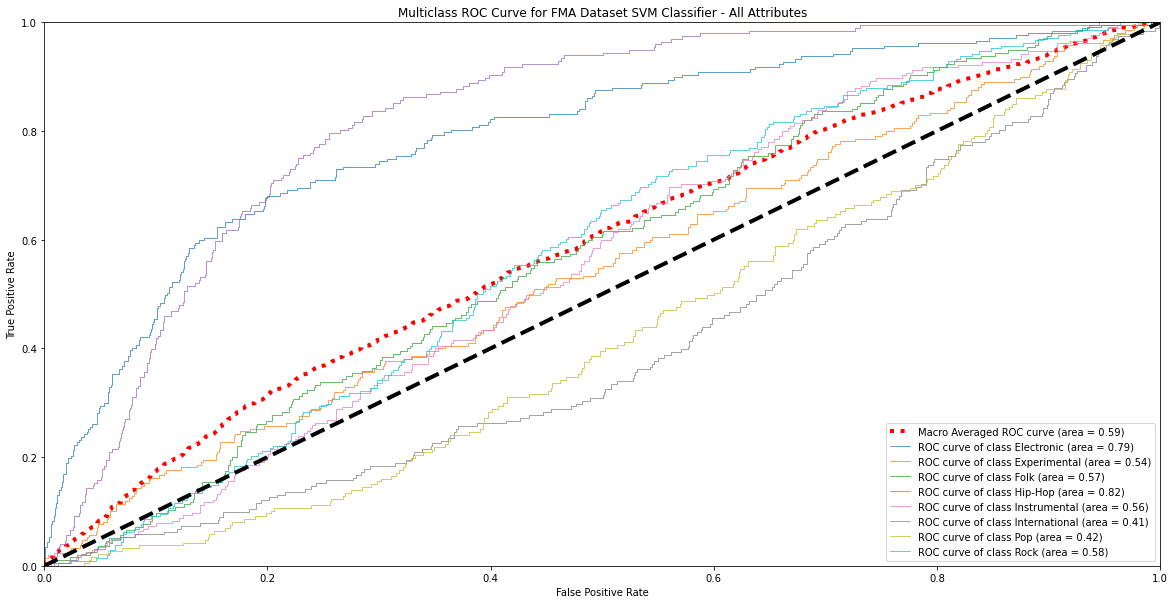

0

In [269]:
#let's see what happens on scaled data
scaler = sk.preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
fma_clf = svm.SVC(decision_function_shape='ovo')
param_grid = {'C': [0.5, 1e0, 1e1, 50, 1e2], 'gamma': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]}
best_mean_fma, best_std_fma, results_fma, fma_cl = best_model_gridsearchCV(X_train_scaled, y_train, param_grid, fma_clf)
fma_report, fma_con_mat = gen_confusion_matrix(X_test_scaled, y_test, fma_cl)
plot_multiclass_roc_curve(X_test_scaled, y_test, fma_cl, 'Multiclass ROC Curve for FMA Dataset SVM Classifier - All Attributes', 'fma_svm_all', 'D:\\Analytics\\ROC Plots\\')

Let's compare results when training on only the newly added features (tempo - dynamic tempo - spectral flatness central moments)

In [270]:
new_features = merged[['mean_dynamic_tempo', 'stdev_dynamic_tempo', 'kurtosis_dynamic_tempo',
       'skew_dynamic_tempo', 'length', 'spectral_flatness_mean',
       'spectral_flatness_stdev', 'spectral_flatness_kurtosis',
       'spectral_flatness_skew']]
X_new_features = new_features.loc[:]
X_new_features_train, X_new_features_test, y_new_features_train, y_new_features_test = train_test_split(X_new_features, y, test_size=0.2)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:  1.0min finished


Best Model Hyperparameters: SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=0.5, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Best Model average classification score: 0.28564674550430025

Grid Search Scores:

0.16604146305707584 0.0014703682840364882 {'C': 0.5, 'gamma': 0.001}
0.1973128420641126 0.006986832742556845 {'C': 0.5, 'gamma': 0.005}
0.21091428850664581 0.005859411925016248 {'C': 0.5, 'gamma': 0.01}
0.23280113858483192 0.005728249388253306 {'C': 0.5, 'gamma': 0.05}
0.2421823690383112 0.005300244087853724 {'C': 0.5, 'gamma': 0.1}
0.27126307173573105 0.007919357512823272 {'C': 0.5, 'gamma': 0.5}
0.2736084098905395 0.011295179025414978 {'C': 0.5, 'gamma': 1}
0.1855857847928069 0.005021363603660022 {'C': 1.0, 'gamma': 0.001}
0.20622300136825644 0.003353356107811079 {'C': 1.0, 'gamma': 0.005}
0.21966844214229866 0.005719868591201329 {'

C:\Users\steve\anaconda3\envs\analytics_conda\lib\site-packages\ipykernel_launcher.py:64: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


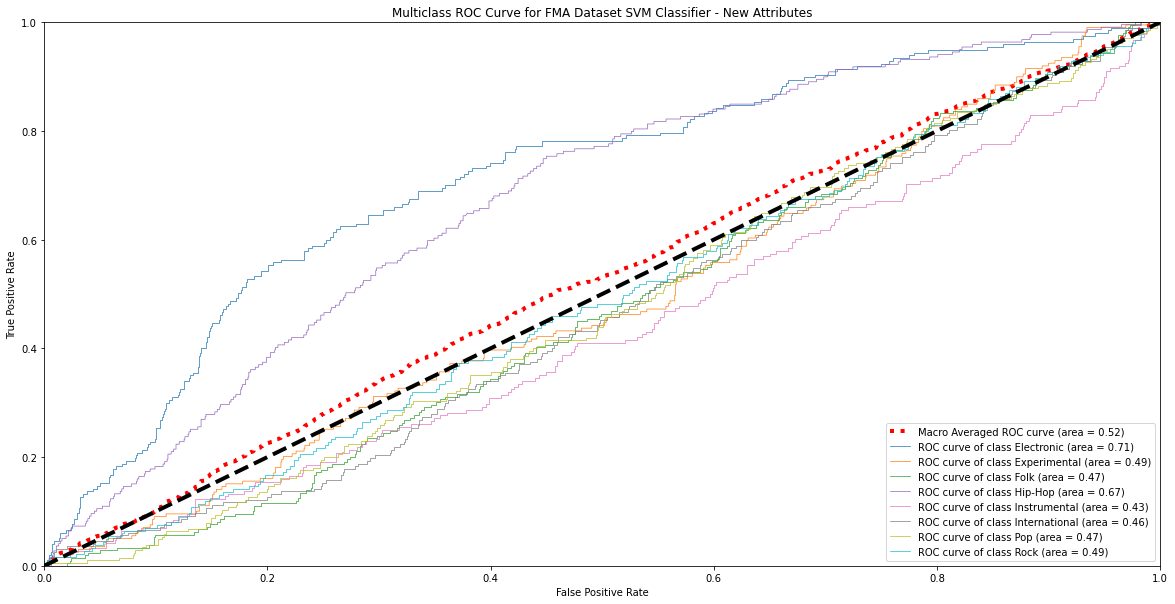

0

In [271]:
scaler = sk.preprocessing.StandardScaler().fit(X_new_features_train)
X_new_features_train_scaled = scaler.transform(X_new_features_train)
X_new_features_test_scaled = scaler.transform(X_new_features_test)
param_grid = {'C': [0.5, 1e0, 1e1, 50, 1e2], 'gamma': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]}
fma_new_clf = svm.SVC(decision_function_shape='ovo')
best_mean_fma_new, best_std_fma_new, results_fma_new, fma_new_cl = best_model_gridsearchCV(X_new_features_train_scaled, y_new_features_train, param_grid, fma_new_clf)
fma_new_report, fma_new_con_mat = gen_confusion_matrix(X_new_features_test_scaled, y_new_features_test, fma_new_cl)
plot_multiclass_roc_curve(X_new_features_test_scaled, y_new_features_test, fma_new_cl, 'Multiclass ROC Curve for FMA Dataset SVM Classifier - New Attributes', 'fma_svm_new', 'D:\\Analytics\\ROC Plots\\')

What about if we leave out the new parameters, and only test on those used in Bahuleyan, 2018?

In [272]:
a, b = merged.columns[1:13], merged.columns[19:43]
org_features = np.concatenate((a,b), axis=0)
X_org_features = merged.loc[:, org_features]
y_org_features = merged.loc[:, 'genre'].to_numpy()
X_org_features_train, X_org_features_test, y_org_features_train, y_org_features_test = train_test_split(X_org_features, y_org_features, test_size=0.2)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:  1.4min finished


Best Model Hyperparameters: SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=0.005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Best Model average classification score: 0.5078150654808444

Grid Search Scores:

0.41541573006254884 0.011221847848797654 {'C': 0.5, 'gamma': 0.001}
0.450751441555903 0.010991277959838758 {'C': 0.5, 'gamma': 0.005}
0.4726393911258796 0.006341127933054197 {'C': 0.5, 'gamma': 0.01}
0.4865539483971853 0.00772287065605033 {'C': 0.5, 'gamma': 0.05}
0.46966770914777173 0.008942932909118156 {'C': 0.5, 'gamma': 0.1}
0.27079383307271304 0.006478518495924343 {'C': 0.5, 'gamma': 0.5}
0.13023773455824864 0.0008102040206411674 {'C': 0.5, 'gamma': 1}
0.42854952599687257 0.010888208789384955 {'C': 1.0, 'gamma': 0.001}
0.4677928313135261 0.00956643580519022 {'C': 1.0, 'gamma': 0.005}
0.4856157154026583 0.0062574283830940415 {'C

C:\Users\steve\anaconda3\envs\analytics_conda\lib\site-packages\ipykernel_launcher.py:64: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


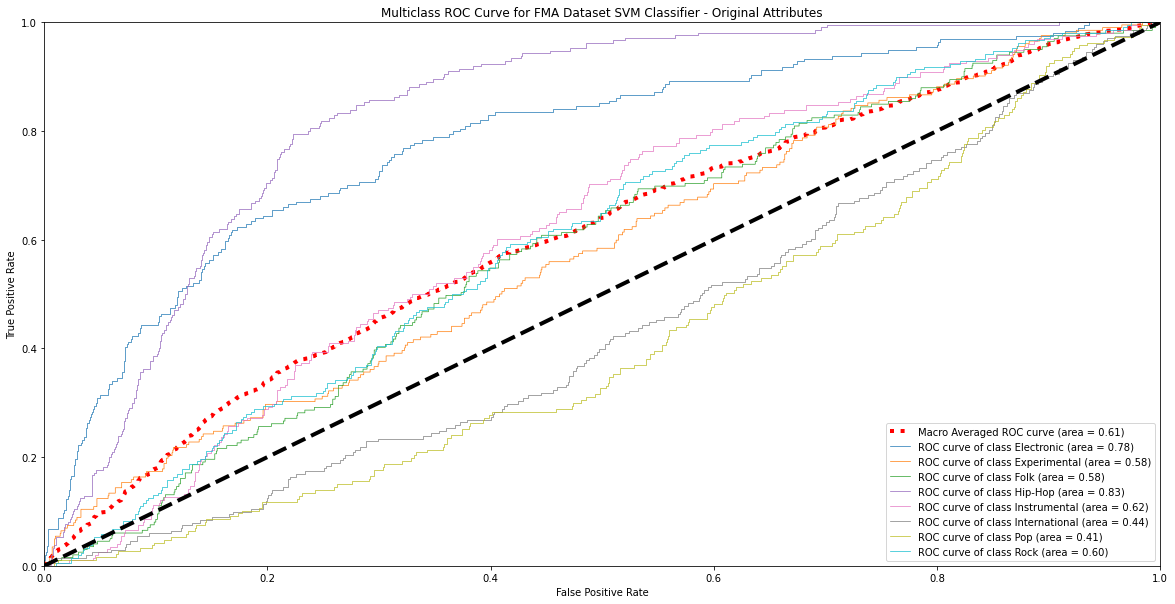

0

In [273]:
scaler = sk.preprocessing.StandardScaler().fit(X_org_features_train)
X_org_features_train_scaled = scaler.transform(X_org_features_train)
X_org_features_test_scaled = scaler.transform(X_org_features_test)
param_grid = {'C': [0.5, 1e0, 1e1, 50, 1e2], 'gamma': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]}
fma_org_clf = svm.SVC(decision_function_shape='ovo')
best_mean_fma_org, best_std_fma_org, results_fma_org, fma_org_cl = best_model_gridsearchCV(X_org_features_train_scaled, y_org_features_train, param_grid, fma_org_clf)
fma_org_report, fma_org_con_mat = gen_confusion_matrix(X_org_features_test_scaled, y_org_features_test, fma_org_cl)
plot_multiclass_roc_curve(X_org_features_test_scaled, y_org_features_test, fma_org_cl, 'Multiclass ROC Curve for FMA Dataset SVM Classifier - Original Attributes', 'fma_svm_org', 'D:\\Analytics\\ROC Plots\\')

## kNN ##

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1

Best Model Hyperparameters: KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=16, p=2,
                     weights='uniform')
Best Model average classification score: 0.45684470289288515

Grid Search Scores:

0.4443381059421423 0.015117447136835513 {'leaf_size': 1, 'n_neighbors': 89}
0.40337629495699767 0.016101068871772723 {'leaf_size': 1, 'n_neighbors': 1}
0.38477057271305715 0.005564258845903106 {'leaf_size': 1, 'n_neighbors': 2}
0.44715280492572324 0.0059887571588000945 {'leaf_size': 1, 'n_neighbors': 8}
0.45684470289288515 0.015695709142458426 {'leaf_size': 1, 'n_neighbors': 16}
0.4521553704065676 0.008996658320951543 {'leaf_size': 1, 'n_neighbors': 32}
0.44809018275996876 0.015122998510320491 {'leaf_size': 1, 'n_neighbors': 64}
0.41150630375293196 0.011893529521741405 {'leaf_size': 1, 'n_neighbors': 256}
0.35678545250195465 0.00823647644644652 {'leaf_size': 1, 'n_neighbors': 1024}
0.444338105

C:\Users\steve\anaconda3\envs\analytics_conda\lib\site-packages\ipykernel_launcher.py:67: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


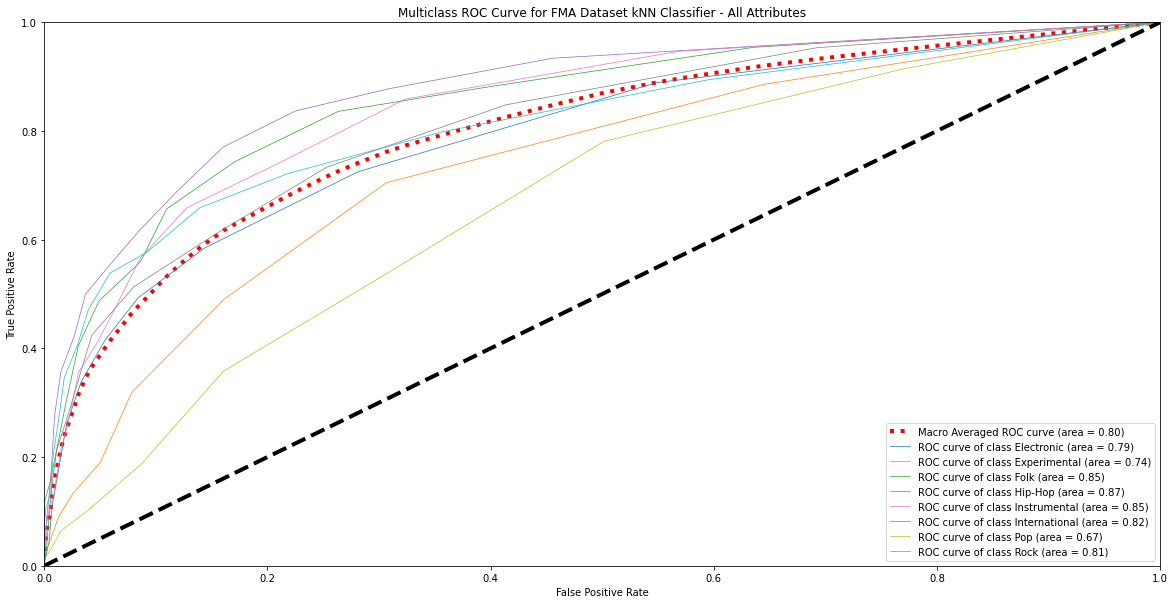

0

In [300]:
# don't have a good idea for k - do parameter search to optimize
test_k = math.sqrt(y.shape[0])
test_k = math.floor(test_k)
param_grid = {'n_neighbors': [test_k, 2**0, 2**1, 2**3, 2**4, 2**5, 2**6, 2**8, 2**10],
             'leaf_size': [1, 5, 10, 15, 30, 45, 60, 100, 250, 500]}
fma_knn_clf = sk.neighbors.KNeighborsClassifier()
best_mean_fma_knn, best_std_fma_knn, results_fma_knn, fma_knn_cl = best_model_gridsearchCV(X_train_scaled, y_train, param_grid, fma_knn_clf)
fma_knn_report, fma_knn_con_mat = gen_confusion_matrix(X_test_scaled, y_test, fma_knn_cl)
plot_multiclass_roc_curve(X_test_scaled, y_test, fma_knn_cl, 'Multiclass ROC Curve for FMA Dataset kNN Classifier - All Attributes', 'fma_knn_all', 'D:\\Analytics\ROC Plots\\', knn=True)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

Best Model Hyperparameters: KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=64, p=2,
                     weights='uniform')
Best Model average classification score: 0.25953796911649724

Grid Search Scores:

0.2537528098123534 0.008252658181453635 {'leaf_size': 1, 'n_neighbors': 89}
0.2112242230258014 0.012900367735370752 {'leaf_size': 1, 'n_neighbors': 1}
0.20356577404222048 0.012265692076665816 {'leaf_size': 1, 'n_neighbors': 2}
0.23373973807662235 0.003980204527875372 {'leaf_size': 1, 'n_neighbors': 8}
0.24624890050820952 0.007635150603080244 {'leaf_size': 1, 'n_neighbors': 16}
0.25766113663017987 0.0064432286069566885 {'leaf_size': 1, 'n_neighbors': 32}
0.25953796911649724 0.010996800388320656 {'leaf_size': 1, 'n_neighbors': 64}
0.24781140050820955 0.005221903546483173 {'leaf_size': 1, 'n_neighbors': 256}
0.21466551016419078 0.017184915179787038 {'leaf_size': 1, 'n_neighbors': 1024}
0.25375280

C:\Users\steve\anaconda3\envs\analytics_conda\lib\site-packages\ipykernel_launcher.py:67: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


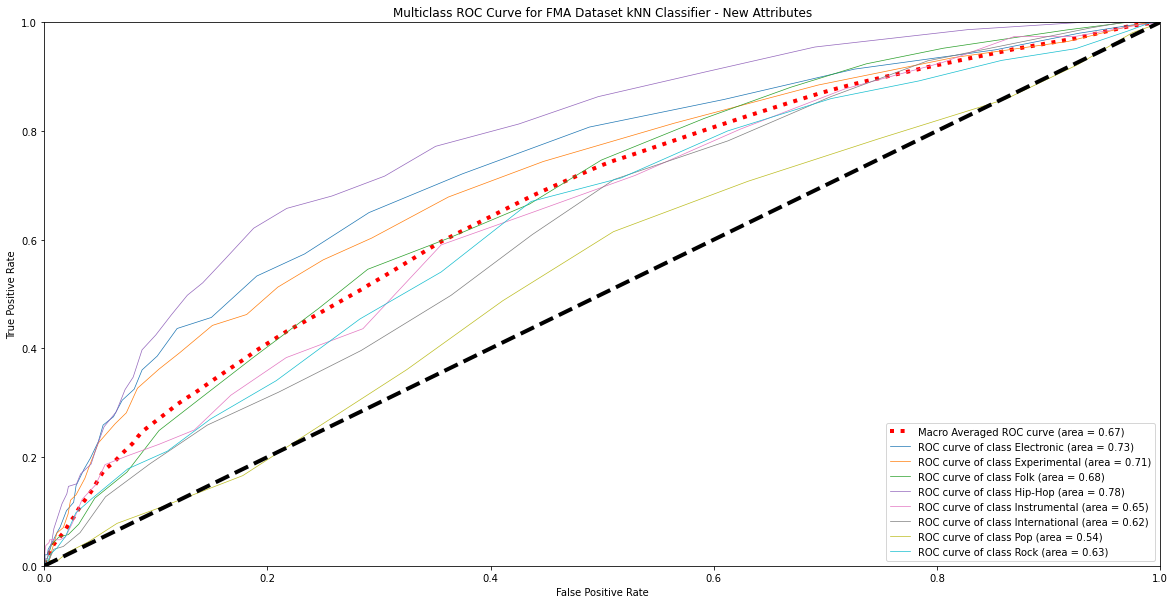

0

In [301]:
fma_new_knn_clf = sk.neighbors.KNeighborsClassifier()
best_mean_fma_new_knn, best_std_fma_new_knn, results_fma_new_knn, fma_new_knn_cl = best_model_gridsearchCV(X_new_features_train_scaled, y_new_features_train, param_grid, fma_new_knn_clf)
fma_new_knn_report, fma_new_knn_con_mat = gen_confusion_matrix(X_new_features_test_scaled, y_new_features_test, fma_new_knn_cl)
plot_multiclass_roc_curve(X_new_features_test_scaled, y_new_features_test, fma_new_knn_cl, 'Multiclass ROC Curve for FMA Dataset kNN Classifier - New Attributes', 'fma_knn_new', 'D:\\Analytics\ROC Plots\\', knn=True)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1

Best Model Hyperparameters: KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform')
Best Model average classification score: 0.4473106430805317

Grid Search Scores:

0.4266698836982017 0.016214806147265684 {'leaf_size': 1, 'n_neighbors': 89}
0.40040449081313517 0.010805816711160751 {'leaf_size': 1, 'n_neighbors': 1}
0.3827382232212666 0.006064184822993055 {'leaf_size': 1, 'n_neighbors': 2}
0.4473106430805317 0.006756168877008919 {'leaf_size': 1, 'n_neighbors': 8}
0.4440259724394058 0.006943727652925317 {'leaf_size': 1, 'n_neighbors': 16}
0.44465207193119627 0.01372374903034382 {'leaf_size': 1, 'n_neighbors': 32}
0.434643642494136 0.015533154575509718 {'leaf_size': 1, 'n_neighbors': 64}
0.39931086297888974 0.017617491901604637 {'leaf_size': 1, 'n_neighbors': 256}
0.35131340402658323 0.00915531363143425 {'leaf_size': 1, 'n_neighbors': 1024}
0.4266698836982017 

C:\Users\steve\anaconda3\envs\analytics_conda\lib\site-packages\ipykernel_launcher.py:67: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


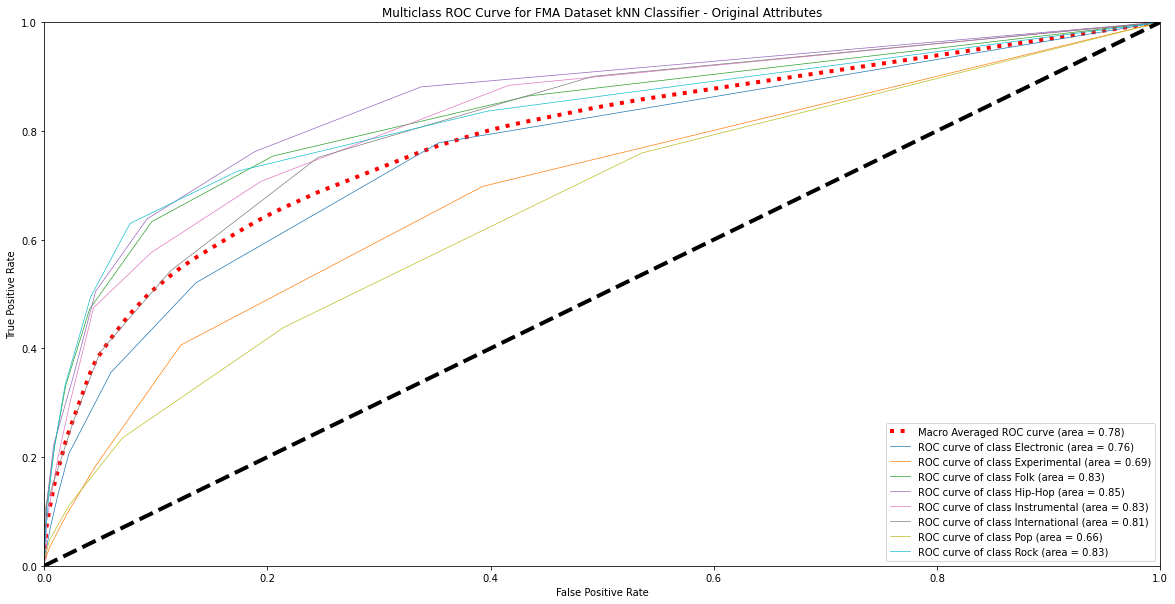

0

In [302]:
fma_org_knn_clf = sk.neighbors.KNeighborsClassifier()
best_mean_fma_org_knn, best_std_fma_org_knn, results_fma_org_knn, fma_org_knn_cl = best_model_gridsearchCV(X_org_features_train_scaled, y_org_features_train, param_grid, fma_org_knn_clf)
fma_org_knn_report, fma_org_knn_con_mat = gen_confusion_matrix(X_org_features_test_scaled, y_org_features_test, fma_org_knn_cl)
plot_multiclass_roc_curve(X_org_features_test_scaled, y_org_features_test, fma_org_knn_cl, 'Multiclass ROC Curve for FMA Dataset kNN Classifier - Original Attributes', 'fma_knn_org', 'D:\\Analytics\\ROC Plots\\', knn=True)

# GTZAN Dataset Model Comparison #
## SVM ##
We'll begin by loading the data as before.

In [274]:
gtzanDataMatrix = pd.read_csv(r'D:/Analytics/gtzan_with_genres.csv', index_col=0)
gtzanDataMatrix.head()

,Unnamed: 0.1,names,x_mean,x_stdev,x_kurtosis,x_skew,zcr_mean,zcr_stdev,zcr_kurtosis,zcr_skew,rms_mean,rms_stdev,rms_kurtosis,rms_skew,tempo,mean_dynamic_tempo,stdev_dynamic_tempo,kurtosis_dynamic_tempo,skew_dynamic_tempo,length,mfcc_mean,mfcc_stdev,mfcc_kurtosis,mfcc_skew,chroma_mean,chroma_stdev,chroma_kurtosis,chroma_skew,spectra_centroid_mean,spectral_centroid_stdev,spectral_centroid_kurtosis,spectral_centroid_skew,spectral_bandwidth_mean,spectral_bandwidth_stdev,spectral_bandwidth_kurtosis,spectral_bandwidth_skew,spectral_contrast_mean,spectral_contrast_stdev,spectral_contrast_kurtosis,spectral_contrast_skew,spectal_rolloff_mean,spectral_rolloff_stdev,spectral_rolloff_kurtosis,spectral_rolloff_skew,spectral_flatness_mean,spectral_flatness_stdev,spectral_flatness_kurtosis,spectral_flatness_skew,genres
0,0,genres\blues\blues.00032.wav,0.000003,0.119223,2.131593,-0.213983,0.039388,0.056197,38.813395,5.745561,0.101321,0.062855,-0.099605,0.735014,123.046875,129.301168,10.835760,1.595533,1.595533,30.013333,-11.992014,72.253908,12.797767,-3.105146,0.468148,0.273645,-0.752662,0.499707,1309.382408,869.518610,8.841975,2.548237,1883.042903,533.051277,-0.645577,0.439897,26.988944,8.184593,-0.552559,0.440817,2763.186256,2165.074296,-0.545990,0.904289,0.001230,0.004043,25.076629,4.909528,blues
1,0,genres\blues\blues.00000.wav,-0.000060,0.140688,1.580552,-0.203222,0.083045,0.027694,3.902308,1.427675,0.130228,0.053167,-0.030803,0.503170,123.046875,124.093677,2.311816,1.082305,1.082305,30.013333,1.938016,42.036021,7.157013,-0.374509,0.593537,0.226949,-0.849441,0.204866,1784.165850,360.241675,5.247317,1.538572,2002.449060,293.057608,0.591216,0.323129,20.526699,8.760242,1.004206,1.394029,3805.839606,949.476395,1.508788,1.012675,0.004498,0.005513,30.448733,4.590178,blues
2,0,genres\blues\blues.00064.wav,-0.000334,0.119734,0.241578,-0.001712,0.146833,0.032543,0.146428,0.289450,0.117432,0.023373,-0.422345,-0.481590,151.999081,151.999081,0.000000,-3.000000,-3.000000,30.013333,-1.575216,35.072604,3.018272,0.175711,0.598542,0.207382,-0.676383,0.451518,2553.361183,328.413826,1.287743,0.883113,2280.266170,181.154832,0.090991,0.687030,22.134404,8.853551,0.806046,1.306034,5148.375700,525.723095,2.049947,1.276500,0.010590,0.007943,5.252939,1.963495,blues
3,0,genres\blues\blues.00096.wav,-0.000150,0.059170,3.533187,0.153153,0.048293,0.035581,32.557536,4.318517,0.051400,0.029287,0.696035,0.859966,123.046875,132.343711,20.657767,2.562216,2.562216,30.013333,-9.551123,80.068193,11.788348,-2.849863,0.424499,0.268058,-0.300136,0.819796,1132.135958,564.913680,17.683608,3.486567,1582.635546,388.926635,1.350205,0.899867,23.636390,5.937637,0.193578,0.540150,2064.964234,1318.396699,4.364260,1.874722,0.000925,0.003346,76.889570,8.151969,blues
4,0,genres\classical\classical.00028.wav,-0.000015,0.067638,1.661933,-0.014755,0.081095,0.026368,0.105268,0.256593,0.062621,0.025577,0.890024,0.595880,151.999081,150.288368,14.782570,1.974377,1.974377,30.013333,-6.849248,64.331276,9.811924,-1.619593,0.428125,0.255016,0.040387,0.980982,1314.282125,377.577101,-0.444125,0.417716,1371.398438,303.087085,-1.129666,0.031504,23.120885,6.298639,0.539516,0.541179,2398.554019,762.448866,-0.776391,0.419222,0.000566,0.000510,3.694602,1.699448,classical


In [275]:
gtzanDataMatrix['genres'] = pd.Categorical(gtzanDataMatrix.genres)
gtzanDataMatrix.genres.value_counts()

rock         100
reggae       100
pop          100
metal        100
jazz         100
hiphop       100
disco        100
country      100
classical    100
blues        100
Name: genres, dtype: int64

Here we see the important difference of the GTZAN dataset. We have significanly less data, and also different genre categories. Rock, reggae, pop, metal, jazz, hiphop, disco, country, classical, and blues make up the genre categories.

In [276]:
gtzanDataMatrix.describe()

,Unnamed: 0.1,x_mean,x_stdev,x_kurtosis,x_skew,zcr_mean,zcr_stdev,zcr_kurtosis,zcr_skew,rms_mean,rms_stdev,rms_kurtosis,rms_skew,tempo,mean_dynamic_tempo,stdev_dynamic_tempo,kurtosis_dynamic_tempo,skew_dynamic_tempo,length,mfcc_mean,mfcc_stdev,mfcc_kurtosis,mfcc_skew,chroma_mean,chroma_stdev,chroma_kurtosis,chroma_skew,spectra_centroid_mean,spectral_centroid_stdev,spectral_centroid_kurtosis,spectral_centroid_skew,spectral_bandwidth_mean,spectral_bandwidth_stdev,spectral_bandwidth_kurtosis,spectral_bandwidth_skew,spectral_contrast_mean,spectral_contrast_stdev,spectral_contrast_kurtosis,spectral_contrast_skew,spectal_rolloff_mean,spectral_rolloff_stdev,spectral_rolloff_kurtosis,spectral_rolloff_skew,spectral_flatness_mean,spectral_flatness_stdev,spectral_flatness_kurtosis,spectral_flatness_skew
count,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.0,-0.000762,0.140651,2.247280,-0.003785,0.103612,0.049374,4.663074,1.401845,0.130930,0.048343,0.249902,0.411876,121.097859,120.689019,10.422006,12.578430,12.578430,30.024075,-0.624951,46.868679,10.656534,-1.405378,0.588832,0.224259,-0.642554,0.234803,2201.780898,631.641179,1.963989,0.898432,2242.541070,350.264251,0.424312,0.267203,20.522848,6.766181,0.976617,0.907638,4571.549304,1264.656250,0.556572,0.314787,0.021561,0.024105,23.813660,3.480943
std,0.0,0.002466,0.068702,2.419407,0.151189,0.041821,0.023429,6.539993,1.006836,0.065683,0.026742,1.709503,0.620968,20.907121,15.792876,10.924985,78.783845,78.783845,0.080910,5.139729,19.277416,5.920338,1.447695,0.101025,0.031721,0.352684,0.405227,715.960600,266.067262,3.372973,0.675915,526.316473,120.035488,1.644073,0.612086,2.179893,2.128023,1.001807,0.480271,1574.791602,495.211922,2.816554,0.786737,0.028860,0.027804,43.856347,2.407638
min,0.0,-0.030527,0.007586,-0.627653,-0.915923,0.021697,0.006640,-1.486844,-1.278935,0.005276,0.002072,-1.498933,-3.148710,69.837416,84.841477,0.000000,-3.000000,-3.000000,29.931973,-21.567975,15.887445,0.601651,-6.623752,0.265530,0.108594,-1.222582,-1.205362,570.040355,88.945216,-1.183790,-1.229784,898.066208,103.861374,-1.503825,-2.177833,13.512489,3.205160,-1.059549,-0.421219,749.140636,121.186297,-1.516271,-2.285210,0.000092,0.000086,-0.553604,-1.194713
25%,0.0,-0.000999,0.095439,0.840500,-0.060546,0.070244,0.032851,0.672728,0.726143,0.086657,0.030686,-0.553932,0.043512,103.359375,109.248052,1.547736,-1.820544,-1.820544,30.000181,-3.234579,33.679596,7.321434,-2.590589,0.524339,0.205187,-0.848185,-0.059230,1627.697311,429.360606,0.176865,0.478885,1907.240605,259.569901,-0.447909,-0.079286,18.790091,4.819734,0.293071,0.524502,3380.069642,879.051311,-0.553644,-0.143165,0.003125,0.004804,4.645148,1.964796
50%,0.0,-0.000038,0.130636,1.619789,-0.005397,0.099503,0.044966,2.367998,1.233599,0.122443,0.042620,-0.206513,0.363730,117.453835,119.999691,6.822087,0.070690,0.070690,30.013333,0.194344,41.510685,10.539561,-1.604773,0.608628,0.226074,-0.749710,0.179702,2209.263090,581.795581,1.101823,0.819435,2221.392843,334.630465,-0.019961,0.224796,20.595159,6.313585,0.854791,0.910111,4658.524473,1214.954591,-0.086291,0.295259,0.010032,0.011918,10.690601,2.857469
75%,0.0,-0.000006,0.187327,2.904833,0.053719,0.131944,0.060232,6.080659,1.897846,0.175682,0.059808,0.441349,0.730723,135.999178,129.199219,16.760449,5.134081,5.134081,30.013333,3.010900,57.082148,12.945821,-0.343617,0.658821,0.246201,-0.585191,0.485400,2691.294667,782.398157,2.691007,1.225195,2578.469836,427.049839,0.666359,0.580861,21.972780,8.796444,1.4209

In [277]:
gtzan_features = gtzanDataMatrix.columns[2:-1]
print(gtzan_features)
X_gtzan = gtzanDataMatrix.loc[:, gtzan_features]
y_gtzan = gtzanDataMatrix.loc[:, 'genres'].to_numpy()
X_gtzan.shape, y_gtzan.shape

Index(['x_mean', 'x_stdev', 'x_kurtosis', 'x_skew', 'zcr_mean', 'zcr_stdev',
       'zcr_kurtosis', 'zcr_skew', 'rms_mean', 'rms_stdev', 'rms_kurtosis',
       'rms_skew', 'tempo', 'mean_dynamic_tempo', 'stdev_dynamic_tempo',
       'kurtosis_dynamic_tempo', 'skew_dynamic_tempo', 'length', 'mfcc_mean',
       'mfcc_stdev', 'mfcc_kurtosis', 'mfcc_skew', 'chroma_mean',
       'chroma_stdev', 'chroma_kurtosis', 'chroma_skew',
       'spectra_centroid_mean', 'spectral_centroid_stdev',
       'spectral_centroid_kurtosis', 'spectral_centroid_skew',
       'spectral_bandwidth_mean', 'spectral_bandwidth_stdev',
       'spectral_bandwidth_kurtosis', 'spectral_bandwidth_skew',
       'spectral_contrast_mean', 'spectral_contrast_stdev',
       'spectral_contrast_kurtosis', 'spectral_contrast_skew',
       'spectal_rolloff_mean', 'spectral_rolloff_stdev',
       'spectral_rolloff_kurtosis', 'spectral_rolloff_skew',
       'spectral_flatness_mean', 'spectral_flatness_stdev',
       'spectral_flatne

((1000, 46), (1000,))

In [278]:
X_gtzan_train, X_gtzan_test, y_gtzan_train, y_gtzan_test = train_test_split(X_gtzan, y_gtzan, test_size=0.2)
scaler = sk.preprocessing.StandardScaler().fit(X_gtzan_train)
X_gtzan_train_scaled = scaler.transform(X_gtzan_train)
X_gtzan_test_scaled = scaler.transform(X_gtzan_test)

In [279]:
new_features_gtzan = gtzanDataMatrix[['mean_dynamic_tempo', 'stdev_dynamic_tempo', 'kurtosis_dynamic_tempo',
       'skew_dynamic_tempo', 'length', 'spectral_flatness_mean',
       'spectral_flatness_stdev', 'spectral_flatness_kurtosis',
       'spectral_flatness_skew']]
X_gtzan_new_features = new_features_gtzan.loc[:]
X_gtzan_new_features_train, X_gtzan_new_features_test, y_gtzan_new_features_train, y_gtzan_new_features_test = train_test_split(X_gtzan_new_features, y_gtzan, test_size=0.2)

In [280]:
scaler = sk.preprocessing.StandardScaler().fit(X_gtzan_new_features_train)
X_gtzan_new_features_train_scaled = scaler.transform(X_gtzan_new_features_train)
X_gtzan_new_features_test_scaled = scaler.transform(X_gtzan_new_features_test)

And on just the original features in the GTZAN set

In [281]:
a, b = gtzanDataMatrix.columns[2:14], gtzanDataMatrix.columns[20:44]
org_features = np.concatenate((a,b), axis=0)
X_gtzan_org_features = gtzanDataMatrix.loc[:, org_features]
y_gtzan_org_features = gtzanDataMatrix.loc[:, 'genres'].to_numpy()
#print(org_features)
X_gtzan_org_features_train, X_gtzan_org_features_test, y_gtzan_org_features_train, y_gtzan_org_features_test = train_test_split(X_gtzan_org_features, y_gtzan_org_features, test_size=0.2)

In [282]:
scaler = sk.preprocessing.StandardScaler().fit(X_gtzan_org_features_train)
X_gtzan_org_features_train_scaled = scaler.transform(X_gtzan_org_features_train)
X_gtzan_org_features_test_scaled = scaler.transform(X_gtzan_org_features_test)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0680s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 160 out of 175 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    1.5s finished
C:\Users\steve\anaconda3\envs\analytics_conda\lib\site-packages\ipykernel_launcher.py:64: DeprecationWarning: scipy.interp is depre

Best Model Hyperparameters: SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Best Model average classification score: 0.71125

Grid Search Scores:

0.40874999999999995 0.010155048005794953 {'C': 0.5, 'gamma': 0.001}
0.5725 0.011592023119369634 {'C': 0.5, 'gamma': 0.005}
0.60125 0.019121323175972954 {'C': 0.5, 'gamma': 0.01}
0.61875 0.050466573095465865 {'C': 0.5, 'gamma': 0.05}
0.5725 0.018791620472966147 {'C': 0.5, 'gamma': 0.1}
0.1275 0.008477912478906594 {'C': 0.5, 'gamma': 0.5}
0.11499999999999999 0.0030618621784789684 {'C': 0.5, 'gamma': 1}
0.50125 0.025433737436719762 {'C': 1.0, 'gamma': 0.001}
0.6087499999999999 0.01286953767623375 {'C': 1.0, 'gamma': 0.005}
0.6375 0.027669929526473326 {'C': 1.0, 'gamma': 0.01}
0.66625 0.028118054698004987 {'C': 1.0, 'gamma': 0.05}
0.6375 0.034686092

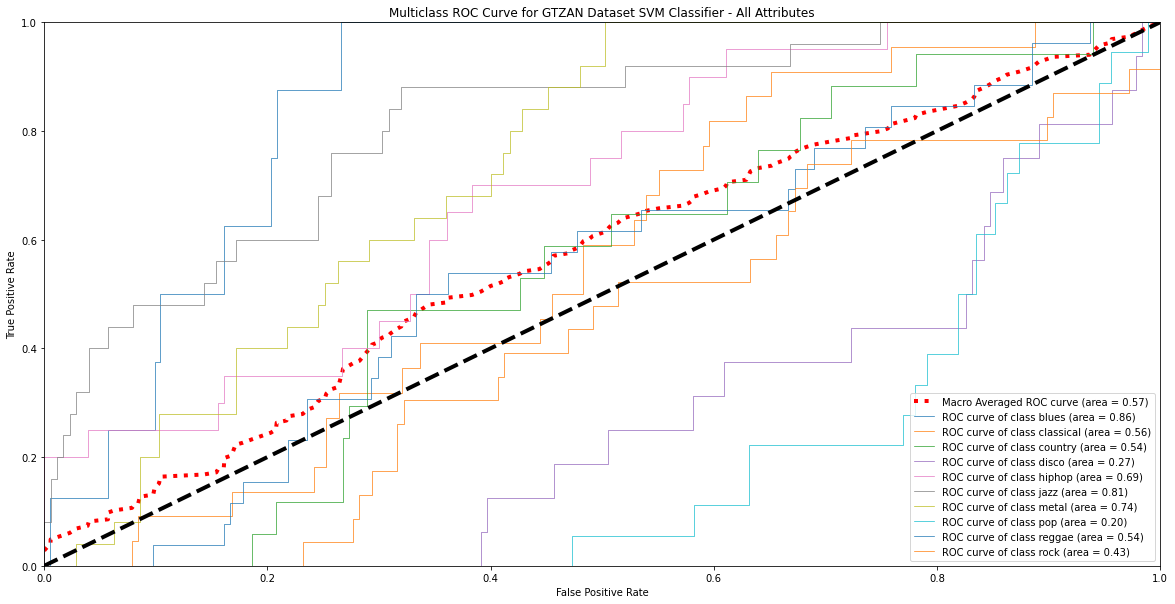

0

In [283]:
#gtzan with all attributes
param_grid = {'C': [0.5, 1e0, 1e1, 50, 1e2], 'gamma': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]}
model_gtzan = sk.svm.SVC(decision_function_shape='ovo')
best_mean_gtzan, best_std_gtzan, results_gtzan, cl = best_model_gridsearchCV(X_gtzan_train_scaled, y_gtzan_train, param_grid, model)
gtzan_report, gtzan_con_mat = gen_confusion_matrix(X_gtzan_test_scaled, y_gtzan_test, cl)
plot_multiclass_roc_curve(X_gtzan_test_scaled, y_gtzan_test, cl, 'Multiclass ROC Curve for GTZAN Dataset SVM Classifier - All Attributes', 'gtzan_svm_all', 'D:\\Analytics\\ROC Plots\\')

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0450s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0929s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    0.9s finished
C:\Users\steve\anaconda3\envs\analytics_conda\lib\site-packages\ipykernel_launcher.py:64: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp i

Best Model Hyperparameters: SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=0.05, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Best Model average classification score: 0.45

Grid Search Scores:

0.1125 0.005590169943749473 {'C': 0.5, 'gamma': 0.001}
0.26875 0.03259601202601325 {'C': 0.5, 'gamma': 0.005}
0.26625 0.03944933459514876 {'C': 0.5, 'gamma': 0.01}
0.34249999999999997 0.02351860965278348 {'C': 0.5, 'gamma': 0.05}
0.33499999999999996 0.02423839928708164 {'C': 0.5, 'gamma': 0.1}
0.32999999999999996 0.02573907535246749 {'C': 0.5, 'gamma': 0.5}
0.33875 0.021794494717703367 {'C': 0.5, 'gamma': 1}
0.17875000000000002 0.03177066256784709 {'C': 1.0, 'gamma': 0.001}
0.26625000000000004 0.03824264635194589 {'C': 1.0, 'gamma': 0.005}
0.305 0.02778263846361608 {'C': 1.0, 'gamma': 0.01}
0.3375 0.024999999999999998 {'C': 1.0, 'gamma': 0.05}
0.3

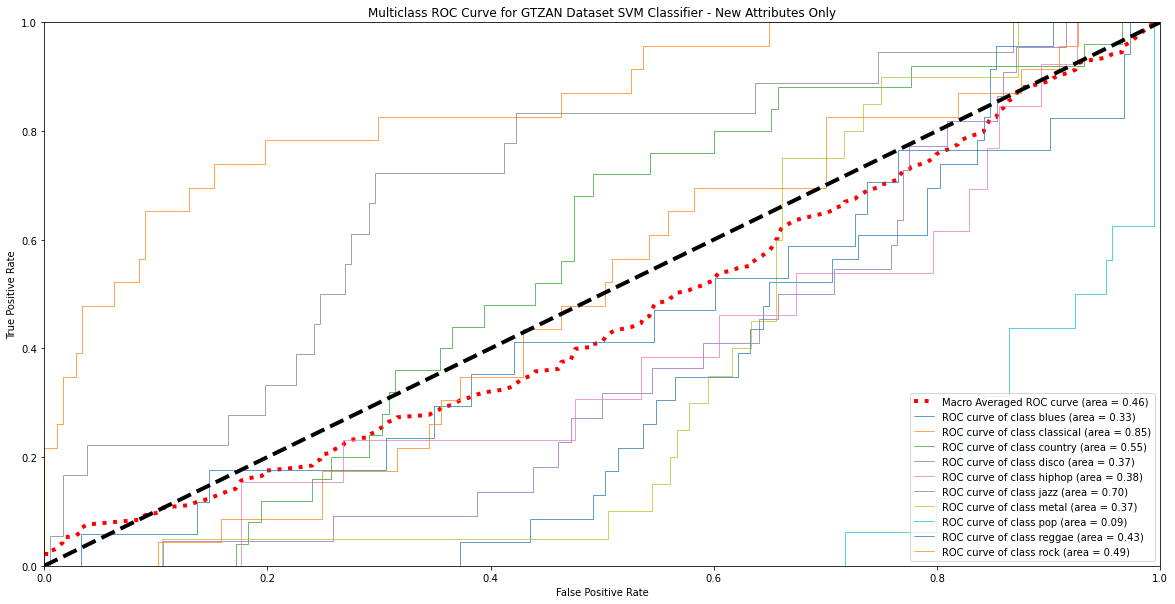

0

In [284]:
#gtzan with new attributes
model_gtzan_new_attr = sk.svm.SVC(decision_function_shape='ovo')
best_mean_gtzan_new, best_std_gtzan_new, results_gtzan_new, cl_new = best_model_gridsearchCV(X_gtzan_new_features_train_scaled, y_gtzan_new_features_train, param_grid, model_gtzan_new_attr)
gtzan_report_new, gtzan_con_mat_new = gen_confusion_matrix(X_gtzan_new_features_test_scaled, y_gtzan_new_features_test, cl_new)
plot_multiclass_roc_curve(X_gtzan_new_features_test_scaled, y_gtzan_new_features_test, cl_new, 'Multiclass ROC Curve for GTZAN Dataset SVM Classifier - New Attributes Only', 'gtzan_svm_new', 'D:\\Analytics\\ROC Plots\\')

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0530s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1799s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    1.3s finished
C:\Users\steve\anaconda3\envs\analytics_conda\lib\site-packages\ipykernel_launcher.py:64: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp i

Best Model Hyperparameters: SVC(C=50, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Best Model average classification score: 0.71

Grid Search Scores:

0.4262499999999999 0.01992172181313654 {'C': 0.5, 'gamma': 0.001}
0.56 0.044826052692602786 {'C': 0.5, 'gamma': 0.005}
0.5800000000000001 0.053822625354027466 {'C': 0.5, 'gamma': 0.01}
0.63125 0.040504629365049116 {'C': 0.5, 'gamma': 0.05}
0.6012500000000001 0.04190763653560052 {'C': 0.5, 'gamma': 0.1}
0.13 0.0025000000000000022 {'C': 0.5, 'gamma': 0.5}
0.11875 0.0 {'C': 0.5, 'gamma': 1}
0.5025000000000001 0.03678484742390541 {'C': 1.0, 'gamma': 0.001}
0.5925 0.05367727638395972 {'C': 1.0, 'gamma': 0.005}
0.61875 0.05405437077609914 {'C': 1.0, 'gamma': 0.01}
0.6575 0.03566335654421776 {'C': 1.0, 'gamma': 0.05}
0.6537499999999999 0.028668362352949287 

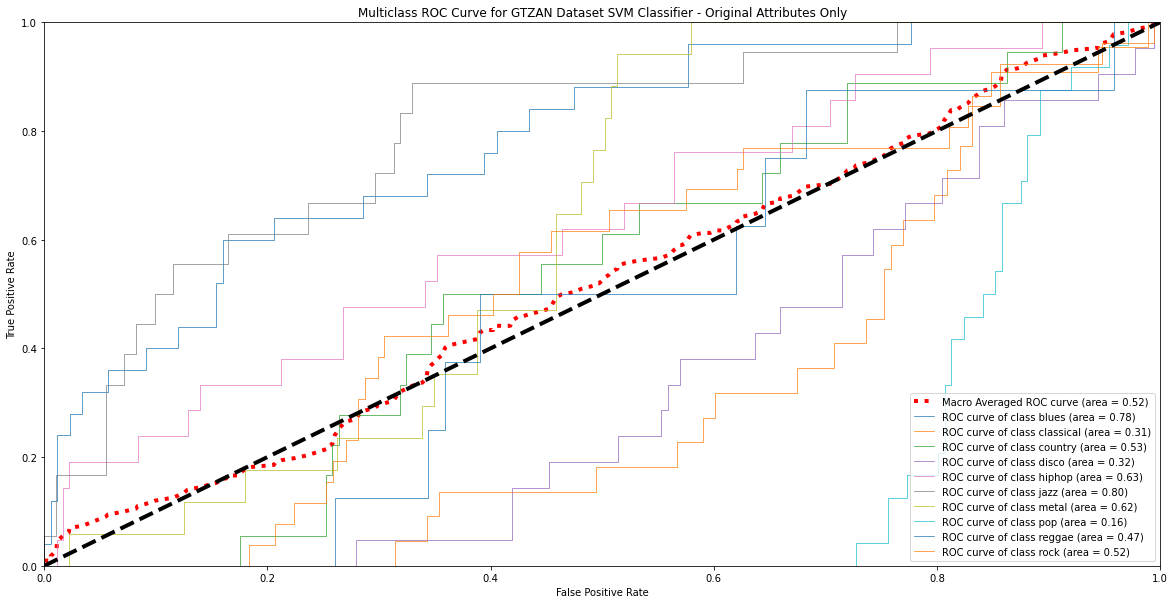

0

In [285]:
#gtzan with old attributes
model_gtzan_old_attr = sk.svm.SVC(decision_function_shape='ovo')
best_mean_gtzan_old, best_std_gtzan_old, results_gtzan_old, cl_old = best_model_gridsearchCV(X_gtzan_org_features_train_scaled, y_gtzan_org_features_train, param_grid, model_gtzan_old_attr)
gtzan_report_old, gtzan_con_mat_old = gen_confusion_matrix(X_gtzan_org_features_test_scaled, y_gtzan_org_features_test, cl_old)
plot_multiclass_roc_curve(X_gtzan_org_features_test_scaled, y_gtzan_org_features_test, cl_old, 'Multiclass ROC Curve for GTZAN Dataset SVM Classifier - Original Attributes Only', 'gtzan_svm_old', 'D:\\Analytics\\ROC Plots\\')

## kNN ##

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1983s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1099s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:    3.6s
[Parallel(n_jo

Best Model Hyperparameters: KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform')
Best Model average classification score: 0.5912499999999999

Grid Search Scores:

0.57125 0.032258719751409856 {'leaf_size': 1, 'n_neighbors': 31}
0.58875 0.03196677963136106 {'leaf_size': 1, 'n_neighbors': 1}
0.5487499999999998 0.016007810593582104 {'leaf_size': 1, 'n_neighbors': 2}
0.5912499999999999 0.021505813167606556 {'leaf_size': 1, 'n_neighbors': 8}
0.57125 0.023913908087136233 {'leaf_size': 1, 'n_neighbors': 16}
0.5549999999999999 0.035222507009013436 {'leaf_size': 1, 'n_neighbors': 32}
0.52 0.029154759474226494 {'leaf_size': 1, 'n_neighbors': 64}
0.41624999999999995 0.019605483926697666 {'leaf_size': 1, 'n_neighbors': 256}
0.19625 0.022220486043288974 {'leaf_size': 1, 'n_neighbors': 512}
0.57125 0.032258719751409856 {'leaf_size': 5, 'n_neighbors': 31}
0.58875 0.0319

C:\Users\steve\anaconda3\envs\analytics_conda\lib\site-packages\ipykernel_launcher.py:67: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


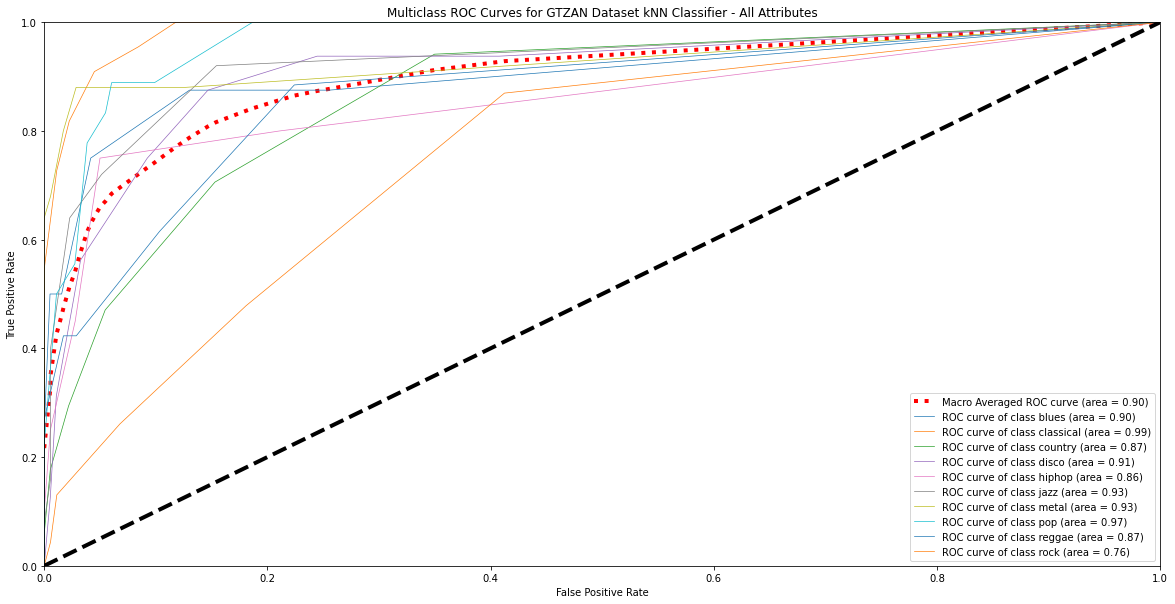

0

In [306]:
# kNN with all attributes
test_k = math.sqrt(y_gtzan.shape[0])
test_k = math.floor(test_k)
param_grid = {'n_neighbors': [test_k, 2**0, 2**1, 2**3, 2**4, 2**5, 2**6, 2**8, 2**9],
             'leaf_size': [1, 5, 10, 15, 30, 45, 60, 100, 200]}
gtzan_knn_clf = sk.neighbors.KNeighborsClassifier()
best_mean_gtzan_knn, best_std_gtzan_knn, results_gtzan_knn, gtzan_knn_cl = best_model_gridsearchCV(X_gtzan_train_scaled, y_gtzan_train, param_grid, gtzan_knn_clf)
gtzan_knn_report, gtzan_knn_con_mat = gen_confusion_matrix(X_gtzan_test_scaled, y_gtzan_test, gtzan_knn_cl)
plot_multiclass_roc_curve(X_gtzan_test_scaled, y_gtzan_test, gtzan_knn_cl, 'Multiclass ROC Curves for GTZAN Dataset kNN Classifier - All Attributes', 'gtzan_knn_all', 'D:\\Analytics\\ROC Plots\\', knn=True)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1776s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0919s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1079s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  

Best Model Hyperparameters: KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=31, p=2,
                     weights='uniform')
Best Model average classification score: 0.355

Grid Search Scores:

0.355 0.02778263846361608 {'leaf_size': 1, 'n_neighbors': 31}
0.32 0.0347760693581089 {'leaf_size': 1, 'n_neighbors': 1}
0.27375 0.03609882269548413 {'leaf_size': 1, 'n_neighbors': 2}
0.345 0.043373378932243675 {'leaf_size': 1, 'n_neighbors': 8}
0.34 0.029208303613869807 {'leaf_size': 1, 'n_neighbors': 16}
0.35 0.01936491673103708 {'leaf_size': 1, 'n_neighbors': 32}
0.32625000000000004 0.015512092057488578 {'leaf_size': 1, 'n_neighbors': 64}
0.26749999999999996 0.015000000000000006 {'leaf_size': 1, 'n_neighbors': 256}
0.1925 0.029947871376777346 {'leaf_size': 1, 'n_neighbors': 512}
0.355 0.02778263846361608 {'leaf_size': 5, 'n_neighbors': 31}
0.32 0.0347760693581089 {'leaf_size': 5, 'n_neighbors': 1}
0.2737

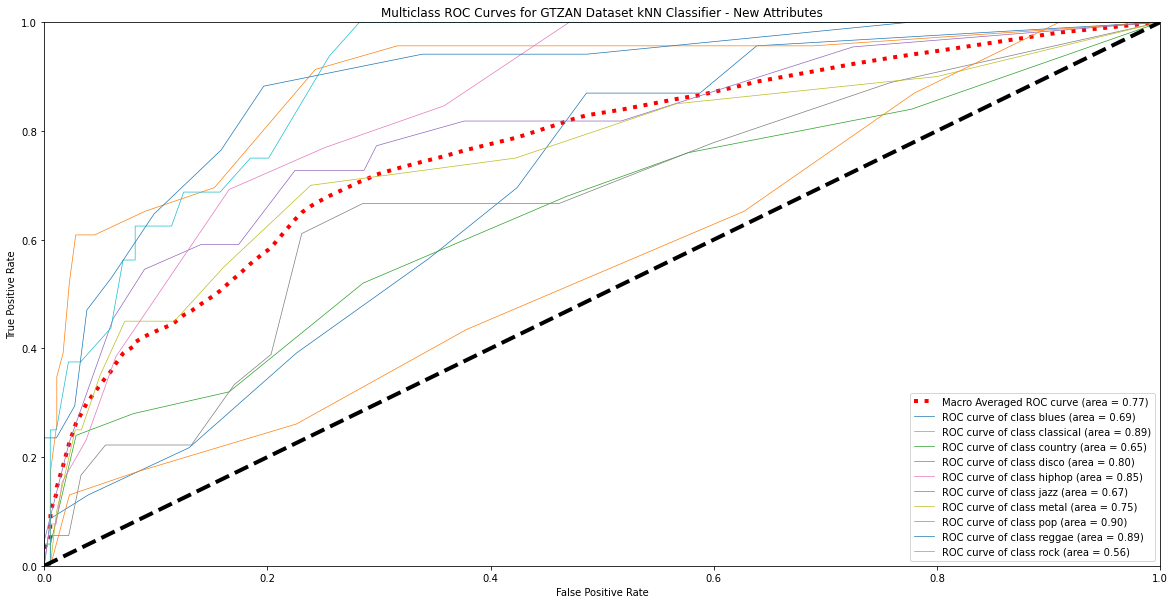

0

In [307]:
# knn with new attributes
gtzan_new_knn_clf = sk.neighbors.KNeighborsClassifier()
best_mean_gtzan_new_knn, best_std_gtzan_new_knn, results_gtzan_new_knn, gtzan_new_knn_cl = best_model_gridsearchCV(X_gtzan_new_features_train_scaled, y_gtzan_new_features_train, param_grid, gtzan_new_knn_clf)
gtzan_new_knn_report, gtzan_new_knn_con_mat = gen_confusion_matrix(X_gtzan_new_features_test_scaled, y_gtzan_new_features_test, gtzan_new_knn_cl)
plot_multiclass_roc_curve(X_gtzan_new_features_test_scaled, y_gtzan_new_features_test, gtzan_new_knn_cl, 'Multiclass ROC Curves for GTZAN Dataset kNN Classifier - New Attributes', 'gtzan_knn_new', 'D:\\Analytics\\ROC Plots\\', knn=True)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1169s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1994s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1894s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:  

Best Model Hyperparameters: KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform')
Best Model average classification score: 0.6

Grid Search Scores:

0.55 0.02128673295740801 {'leaf_size': 1, 'n_neighbors': 31}
0.5962500000000001 0.02783882181415012 {'leaf_size': 1, 'n_neighbors': 1}
0.56125 0.049592086062193445 {'leaf_size': 1, 'n_neighbors': 2}
0.6 0.02531057091414575 {'leaf_size': 1, 'n_neighbors': 8}
0.59375 0.016298006013006624 {'leaf_size': 1, 'n_neighbors': 16}
0.55 0.026809513236909013 {'leaf_size': 1, 'n_neighbors': 32}
0.5275000000000001 0.05071365693775197 {'leaf_size': 1, 'n_neighbors': 64}
0.4462499999999999 0.02256933760658473 {'leaf_size': 1, 'n_neighbors': 256}
0.2 0.0223606797749979 {'leaf_size': 1, 'n_neighbors': 512}
0.55 0.02128673295740801 {'leaf_size': 5, 'n_neighbors': 31}
0.595 0.026925824035672532 {'leaf_size': 5, 'n_neighbors': 1}


C:\Users\steve\anaconda3\envs\analytics_conda\lib\site-packages\ipykernel_launcher.py:67: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


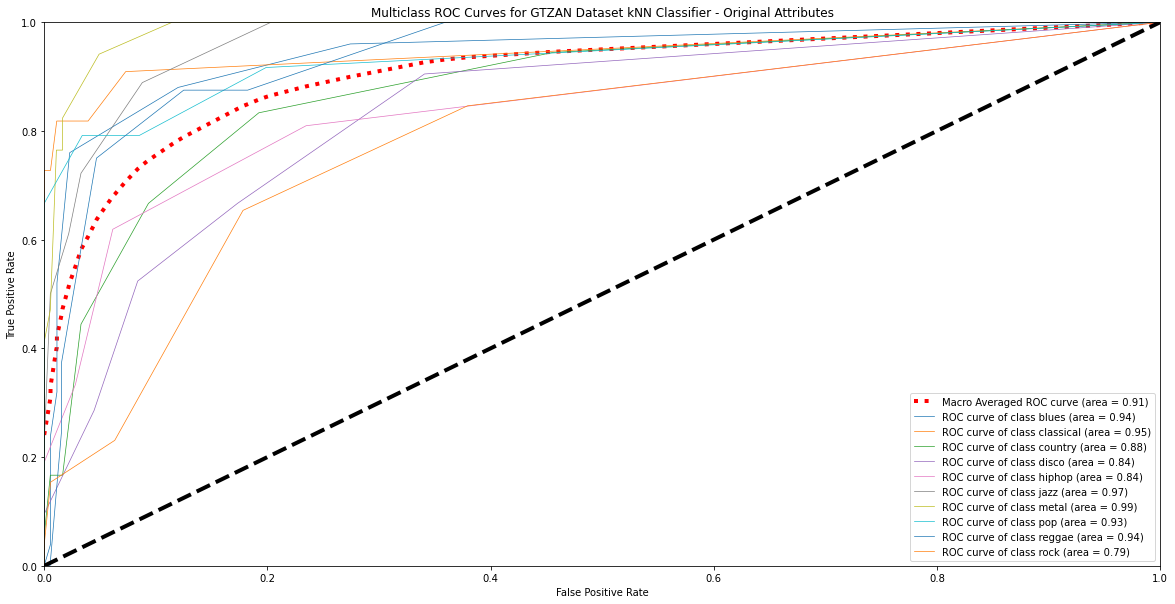

0

In [308]:
gtzan_org_knn_clf = sk.neighbors.KNeighborsClassifier()
best_mean_gtzan_org_knn, best_std_gtzan_org_knn, results_gtzan_org_knn, gtzan_org_knn_cl = best_model_gridsearchCV(X_gtzan_org_features_train_scaled, y_gtzan_org_features_train, param_grid, gtzan_org_knn_clf)
gtzan_org_knn_report, gtzan_org_knn_con_mat = gen_confusion_matrix(X_gtzan_org_features_test_scaled, y_gtzan_org_features_test, gtzan_org_knn_cl)
plot_multiclass_roc_curve(X_gtzan_org_features_test_scaled, y_gtzan_org_features_test, gtzan_org_knn_cl, 'Multiclass ROC Curves for GTZAN Dataset kNN Classifier - Original Attributes', 'gtzan_knn_org', 'D:\\Analytics\\ROC Plots\\', knn=True)

# Inference #

Let's conduct tests for statistical significance for the following:

For Each Dataset:<br>
1. Difference between Original Attribute Space and Expanded Attribute Space
2. Difference within Datasets between kNN and SVC
3. Difference between datasets

In every case, we'll be testing that<br>
$H_o: accuracy_1 = accuracy_2$<br>
$H_a: accuracy_1 \neq accuracy_2$

In [312]:
# FMA - Diff Expanded and Original
p1 = cross_val_t_test(best_mean_fma, best_mean_fma_org, best_std_fma, best_std_fma_org, 5)
p2 = cross_val_t_test(best_mean_fma_knn, best_mean_fma_org_knn, best_std_fma_knn, best_std_fma_org_knn, 5)
print(2*p1)
print(2*p2)

0.21772345555897044
0.28023450636334246


The difference between the expanded attribute set and the original attribute set is not significant - for either kNN or SVM.

In [319]:
# GTZAN - Diff Expanded and Original
p1 = cross_val_t_test(best_mean_gtzan, best_mean_gtzan_old, best_std_gtzan, best_std_gtzan_old, 5)
p2 = cross_val_t_test(best_mean_gtzan_knn, best_mean_gtzan_org_knn, best_std_gtzan_knn, best_std_gtzan_org_knn, 5)
print(2*p1)
print(2*p2)

0.9582311538689228
0.5874632399359285


Neither are significant for GTZAN

In [321]:
# FMA - Diff SVC and kNN
p1 = cross_val_t_test(best_mean_fma, best_mean_fma_knn, best_std_fma, best_std_fma_knn, 5)
print(2*p1)

0.00368535681519222


The result is significant at the $\alpha = 0.005$ level (0.5%)

In [322]:
# GTZAN - Diff SVC and kNN
p1 = cross_val_t_test(best_mean_gtzan, best_mean_gtzan_knn, best_std_gtzan, best_std_gtzan_knn, 5)
print(2*p1)

0.0024133433768323


The result is significant at the $\alpha = 0.005$ level (0.5%) 

In [323]:
# Diff b/w Datasets - SVM
p1 = cross_val_t_test(best_mean_fma, best_mean_gtzan, best_std_fma, best_std_gtzan, 5)
print(2*p1)

0.0003327836563942199


The result is significant at the $\alpha = 0.0005$ level (0.05%)

In [324]:
# Diff b/w Datasets - kNN
p1 = cross_val_t_test(best_mean_fma_knn, best_mean_gtzan_knn, best_std_fma_knn, best_std_gtzan_knn, 5)
print(2*p1)

0.00035097300983100155


The result is significant at the $\alpha = 0.0005$ level (0.05%)